# Advanced Physical Modelling

It's unlikely that the `cloud()` model will be sufficient for all your modelling needs. In this notebook, we demonstrate the process the UCLCHEM team usually follow to model more complex systems such as hot cores or shocks.

In [1]:
import uclchem
import pandas as pd
import matplotlib.pyplot as plt

## Initial Conditions


In [3]:
# set a parameter dictionary for phase 1 collapse model

outSpecies = "SO CO"
param_dict = {
    "switch": 0,#stop at finalTime
    "collapse": 1,#increase density in freefall
    "outSpecies": outSpecies, #species to return abundances for
    "initialDens": 1e2, #starting density
    "initialTemp": 10.0,#temperature of gas
    "finalDens": 1e6,#final density - collapse stops here
    "finalTime": 6.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv:":1.0, #visual extinction at cloud edge.
    "outputFile": "../examples/test-output/phase1-full.dat",#full UCLCHEM output
    "abundSaveFile": "../examples/test-output/startcollapse.dat",#save final abundances to file
}
success_flag, abunds = uclchem.cloud(param_dict)


In [4]:
print(success_flag,abunds)

0 [1.95585829e-15 3.99833913e-13]


In [5]:
phase1_df=uclchem.read_output_file("../examples/test-output/phase1-full.dat")
phase1_df.head()

,Time,Density,gasTemp,av,point,H,#H,H+,@H,H2,...,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE,zeta,radfield
0,0.000000e+00,100100.0,10.0,11.644,1,1.470530e-08,3.282830e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
1,1.000000e-07,100100.0,10.0,11.653,1,1.470530e-08,3.282830e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
2,1.000000e-06,100100.0,10.0,11.653,1,1.470530e-08,3.282820e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
3,1.000000e-05,100100.0,10.0,11.653,1,1.470530e-08,3.282690e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190330e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0
4,1.000000e-04,100100.0,10.0,11.653,1,1.470530e-08,3.281360e-12,1.705670e-11,3.284720e-08,0.040093,...,4.328070e-21,6.150340e-18,9.628860e-14,2.190340e-12,1.104670e-09,3.253640e-09,0.460209,0.000005,1.0,1.0


Finally, you will want to plot your results. This can be done with any plotting library but UCLCHEM does provide a few functions to make quick plots. Note the use of $ symbols in the species list below, this gets the total ice abundance of a species. For two phase models, this is just the surface abudance but for three phase it is the sum of surface and bulk.

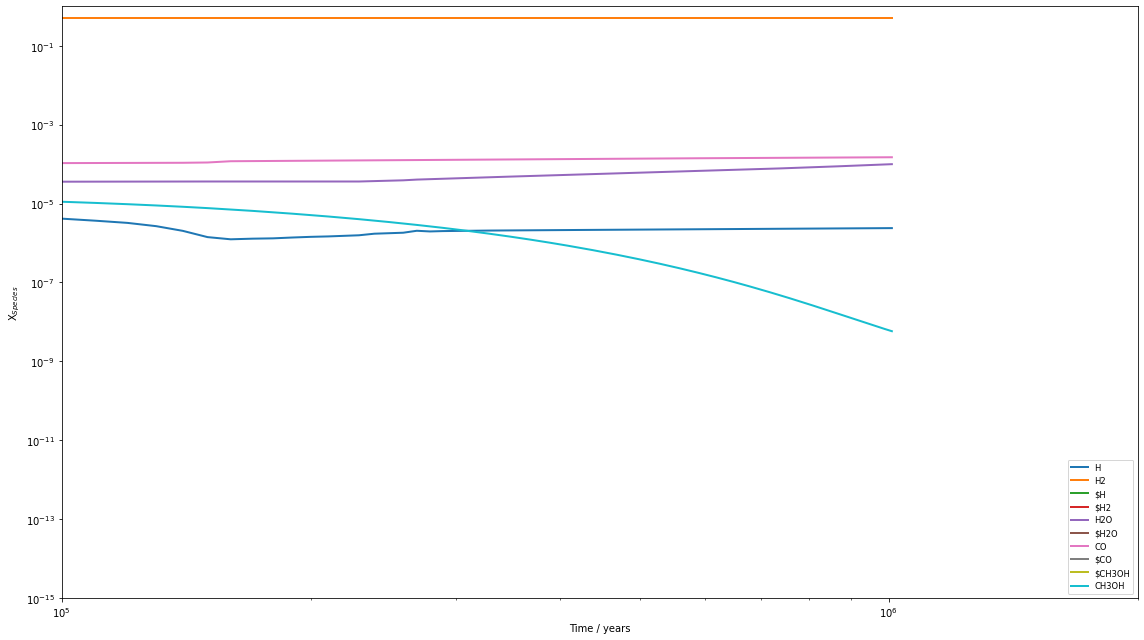

In [9]:
species=["H","H2","$H","$H2","H2O","$H2O","CO","$CO","$CH3OH","CH3OH"]
fig,ax=uclchem.create_abundance_plot(phase1_df,species)
ax=ax.set(xscale="log",ylim=(1e-15,1),xlim=(1e5,2e6))

# Phase 2

Phase 2 is essentially turning on whatever physics the module is supposed to model. We do this by setting the `phase` parameter to 2.

We also want to continue where we left off with phase 1, we do this by using `abundLoadFile` to tell UCLCHEM where to load the initial abundances from. We set this to the file that we designated as `abundSaveFile` in phase 1. Since we don't want to run a third model continuing from this one, we remove abundSaveFile from this dictionary with `pop`

In [6]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e5
param_dict["finalTime"]=1e6
param_dict["switch"]=0

param_dict.pop("abundSaveFile") #this is still set to startcollapse.dat from phase 1 so remove it or change it.
param_dict["abundLoadFile"]="../examples/test-output/startcollapse.dat"
param_dict["outputFile"]="../examples/test-output/phase1-full.dat"


success_flag,abunds=uclchem.hot_core(temp_indx=3,max_temperature=300.0,param_dict=param_dict)

In [7]:
print(success_flag,abunds)

0 [3.20007358e-06 1.49702246e-04]


In [8]:
phase2_df=uclchem.read_output_file("../examples/test-output/phase2-full.dat")
phase2_df.tail()

,Time,Density,gasTemp,av,point,H,#H,H+,@H,H2,...,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE,zeta,radfield
189,960100.0,100000.0,300.0,11.644,1,0.000025,2.823680e-30,1.894050e-12,1.000000e-30,0.499919,...,7.843910e-15,4.510850e-14,1.697770e-10,1.000000e-30,1.000000e-30,1.317550e-07,1.981910e-19,5.428660e-30,1.0,1.0
190,970100.0,100000.0,300.0,11.644,1,0.000025,2.845060e-30,1.887980e-12,1.000000e-30,0.499918,...,7.820550e-15,4.380380e-14,1.687010e-10,1.000000e-30,1.000000e-30,1.316820e-07,1.981910e-19,5.480190e-30,1.0,1.0
191,980100.0,100000.0,300.0,11.644,1,0.000025,2.866450e-30,1.881950e-12,1.000000e-30,0.499918,...,7.796320e-15,4.253770e-14,1.676330e-10,1.000000e-30,1.000000e-30,1.316040e-07,1.981910e-19,5.531730e-30,1.0,1.0
192,990100.0,100000.0,300.0,11.644,1,0.000025,2.887850e-30,1.875970e-12,1.000000e-30,0.499917,...,7.771220e-15,4.130890e-14,1.665710e-10,1.000000e-30,1.000000e-30,1.315210e-07,1.981910e-19,5.583280e-30,1.0,1.0
193,1000000.0,100000.0,300.0,11.644,1,0.000025,2.909250e-30,1.870040e-12,1.000000e-30,0.499917,...,7.745290e-15,4.011620e-14,1.655160e-10,1.000000e-30,1.000000e-30,1.314340e-07,1.981910e-19,5.634830e-30,1.0,1.0


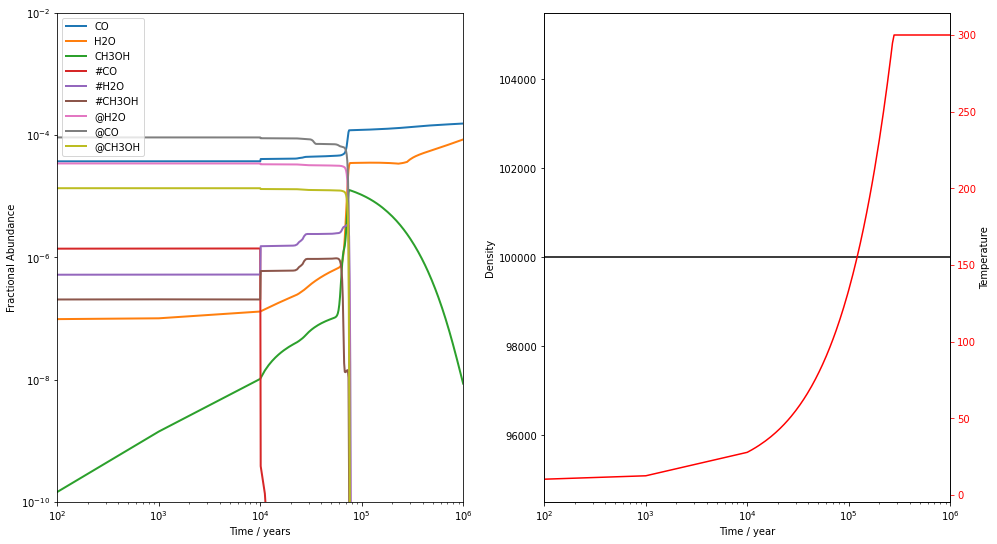

In [9]:
species=["CO","H2O","CH3OH","#CO","#H2O","#CH3OH","@H2O","@CO","@CH3OH"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.plot_species(ax,phase2_df,species)
settings=ax.set(yscale="log",xlim=(1e2,1e6),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(phase2_df["Time"],phase2_df["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(phase2_df["Time"],phase2_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1e2,1e6))
ax3.tick_params(axis='y', colors='red')

In [10]:
#set a parameter dictionary for phase 1 collapse model

outSpecies="SO CO"
param_dict = {"switch": 0, "collapse": 1, "writeStep": 1,
               "outSpecies": outSpecies, "initialDens": 1e2, "initialTemp":10.0,
               "finalDens":1e6, "finalTime":6.0e6,
               "outputFile":"../examples/test-output/phase1-full.dat",
               "abundSaveFile":"../examples/test-output/startcollapse.dat"}

In [10]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e5
param_dict["finalTime"]=1e6
param_dict["switch"]=0
if "abundSaveFile" in param_dict:
    param_dict.pop("abundSaveFile")
param_dict["abundLoadFile"]="../examples/test-output/startcollapse.dat"
param_dict["outputFile"]="../examples/test-output/shock.dat"


success_flag,abunds,dissipation_time=uclchem.cshock(shock_vel=40,param_dict=param_dict)

In [15]:
phase2_df=uclchem.read_output_file("../examples/test-output/shock.dat")
phase2_df=phase2_df[phase2_df["Time"]<20.0*dissipation_time]

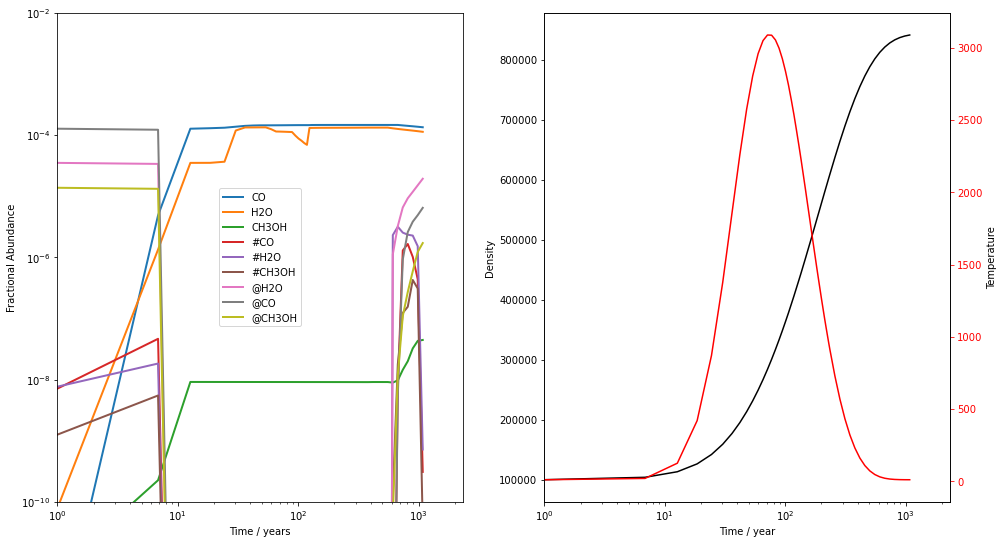

In [18]:
species=["CO","H2O","CH3OH","#CO","#H2O","#CH3OH","@H2O","@CO","@CH3OH"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.plot_species(ax,phase2_df,species)
settings=ax.set(yscale="log",xlim=(1,20*dissipation_time),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(phase2_df["Time"],phase2_df["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(phase2_df["Time"],phase2_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1,20*dissipation_time))
ax3.tick_params(axis='y', colors='red')

In [2]:
#change other bits of input to set up phase 2
#set a parameter dictionary for phase 1 collapse model

param_dict = {"switch": 0, "collapse": 1, "writeStep": 1,
                "initialDens": 1e2, "initialTemp":10.0,
               "finalDens":1e3, "finalTime":6.0e6,
               "outputFile":"../examples/test-output/phase1-full.dat",
               "abundSaveFile":"../examples/test-output/shockstart.dat"}
#result=uclchem.cloud(param_dict)
#print(result)
param_dict["initialDens"]=1e3
param_dict["finalTime"]=1e6
param_dict["switch"]=0
shock_vel=10.0
if "abundSaveFile" in param_dict:
    param_dict.pop("abundSaveFile")
param_dict["abundLoadFile"]="../examples/test-output/shockstart.dat"
param_dict["outputFile"]="../examples/test-output/shock.dat"


result=uclchem.jshock(shock_vel=shock_vel,param_dict=param_dict)


{'switch': 0, 'collapse': 1, 'writeStep': 1, 'initialDens': 1000.0, 'initialTemp': 10.0, 'finalDens': 1000.0, 'finalTime': 1000000.0, 'outputFile': '../examples/test-output/shock.dat', 'abundLoadFile': '../examples/test-output/shockstart.dat'}
 Cannot have collapse on during jshock
 setting collapse=0 and continuing


In [ ]:
result

In [3]:
shock_df=uclchem.read_output_file(param_dict["outputFile"])

[None, None]

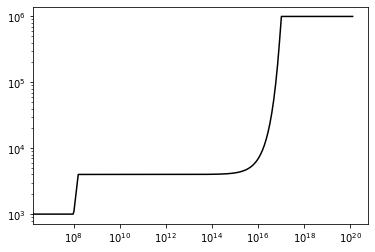

In [4]:
fig,ax=plt.subplots()
ax.plot(shock_df["Time"]*365*24*60*60*40.0e5,shock_df["Density"],color="black")
ax.set(xscale="log",yscale="log")